requirements

lightgbm

graphviz

optuna

autogluon

sklearn

pandas

numpy

In [860]:
import pandas as pd
import numpy as np
import warnings 
warnings.filterwarnings('ignore')
df = pd.read_csv("jeju_최종_최종_최종_수정.csv", encoding="cp949")
df.관광객수 = df.관광객수.str.replace(",","")
df.관광객수=df.관광객수.astype(np.float64)

In [861]:
df = df[df['콘텐츠분류'].isna()==False]

In [863]:
df =df[df['콘텐츠분류']!='축제/행사']

In [864]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2336 entries, 0 to 2392
Data columns (total 14 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   콘텐츠분류      2336 non-null   object 
 1   관광객수       2336 non-null   float64
 2   관광지면적      2336 non-null   float64
 3   ratio      2336 non-null   float64
 4   카드사용금액     2336 non-null   float64
 5   조회수        2336 non-null   float64
 6   좋아요수       2336 non-null   float64
 7   북마크수       2336 non-null   float64
 8   소셜네트워크공유수  2336 non-null   float64
 9   인기점수       2336 non-null   float64
 10  사진공유수      2336 non-null   float64
 11  관광지개수      2336 non-null   float64
 12  평점         2336 non-null   float64
 13  seg면적      2336 non-null   int64  
dtypes: float64(12), int64(1), object(1)
memory usage: 273.8+ KB


In [865]:
# df['ratio'] = df['ratio']*df['ratio']

In [866]:
df['오버투어리즘'] = df['관광객수']/df['관광지면적']

In [867]:
# '콘텐츠분류' 열의 고유한 값과 그에 대응하는 숫자를 매핑한 딕셔너리
#content_mapping = {'숙박': 0, '음식점': 1, '관광지': 2, '테마여행': 3, '쇼핑': 4}

# '콘텐츠분류' 열을 숫자로 매핑
#df['콘텐츠분류'] = df['콘텐츠분류'].map(content_mapping)

In [868]:
df[['콘텐츠분류','관광객수']].groupby("콘텐츠분류").sum()

,관광객수
콘텐츠분류,
관광지,4.650645e+09
쇼핑,5.781661e+08
숙박,5.198320e+09
음식점,6.348535e+09
테마여행,1.980240e+08


In [869]:
#feature_cols = ['관광지개수','ratio','카드사용금액','조회수','평점','좋아요수','리뷰수','북마크수','소셜네트워크공유수','인기점수','사진공유수','콘텐츠분류','유네스코유무']

#feature_cols = ['관광지개수','ratio' ,'카드사용금액','조회수','북마크수','인기점수','사진공유수']
#feature_cols = ['관광지개수','ratio','카드사용금액','조회수','인기점수','콘텐츠분류']

#feature_cols = ['관광지개수','ratio','카드사용금액','조회수','평점','좋아요수','리뷰수','북마크수','소셜네트워크공유수','인기점수','사진공유수','콘텐츠분류','유네스코유무']
feature_cols = ['관광지개수','ratio' ,'카드사용금액','조회수','좋아요수', '북마크수','인기점수','콘텐츠분류']

X = df[feature_cols]

y = df['관광객수']/df['관광지면적'] # 오버투어리즘 계산 

In [870]:

# 사분위수 계산
q1 = y.quantile(0.25)
q3 = y.quantile(0.75)

# IQR 계산
iqr = q3 - q1

# 아웃라이어의 경계 정의
lower_bound = q1 - 1.5 * iqr
upper_bound = q3 + 1.5 * iqr

# 아닌거 찾기 (한번만 실행!!)
X = X.loc[~(y > lower_bound) | (y < upper_bound)]
y = y[~(y > lower_bound) | (y < upper_bound)]

# 결과 출력
print("사분위수(Q1):", q1)
print("사분위수(Q3):", q3)
print("IQR:", iqr)
print(len(y))
print(len(X))

사분위수(Q1): 838.5726984470663
사분위수(Q3): 10324.972602739726
IQR: 9486.39990429266
2177
2177


In [871]:
# '콘텐츠분류' 열의 고유한 값과 그에 대응하는 숫자를 매핑한 딕셔너리
content_mapping = {'숙박': 0, '음식점': 1, '관광지': 2, '테마여행': 3, '쇼핑': 4}

# '콘텐츠분류' 열을 숫자로 매핑
X['콘텐츠분류'] = X['콘텐츠분류'].map(content_mapping)


In [872]:
X

,관광지개수,ratio,카드사용금액,조회수,좋아요수,북마크수,인기점수,콘텐츠분류
0,25.0,27.5,19.0,979.0,0.0,1.0,1958.0,0
1,25.0,27.5,19.0,1043.0,0.0,1.0,2086.0,0
2,25.0,27.5,19.0,2118.0,0.0,1.0,4236.0,1
3,25.0,27.5,19.0,7851.0,0.0,14.0,15707.0,2
4,25.0,27.5,19.0,5153.0,0.0,47.0,10321.0,1
...,...,...,...,...,...,...,...,...
2387,26.0,95.7,26.5,4431.0,1.0,32.0,8875.0,1
2388,26.0,95.7,26.5,3640.0,1.0,17.0,7288.0,1
2389,26.0,95.7,26.5,8418.0,2.0,4.0,16842.0,2
2390,26.0,95.7,26.5,1998.0,0.0,4.0,3996.0,0


In [873]:
X.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2177 entries, 0 to 2392
Data columns (total 8 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   관광지개수   2177 non-null   float64
 1   ratio   2177 non-null   float64
 2   카드사용금액  2177 non-null   float64
 3   조회수     2177 non-null   float64
 4   좋아요수    2177 non-null   float64
 5   북마크수    2177 non-null   float64
 6   인기점수    2177 non-null   float64
 7   콘텐츠분류   2177 non-null   int64  
dtypes: float64(7), int64(1)
memory usage: 153.1 KB


In [874]:
y.describe()

count     2177.000000
mean      5330.958321
std       5604.736707
min          0.184432
25%        693.977448
50%       3072.175641
75%       9145.274014
max      24511.317073
dtype: float64

# 모델학습

In [875]:
import sklearn

In [876]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import mean_squared_error, r2_score, median_absolute_error
import lightgbm as lgb


ss = StandardScaler()
X = ss.fit_transform(X)

X_train, X_valid, y_train, y_valid = train_test_split(X, y, random_state=42)


In [877]:
X

array([[-1.55983869,  0.60489581, -0.87006548, ..., -0.20745895,
        -0.23606125, -1.18207029],
       [-1.55983869,  0.60489581, -0.87006548, ..., -0.20745895,
        -0.23381679, -1.18207029],
       [-1.55983869,  0.60489581, -0.87006548, ..., -0.20745895,
        -0.196117  , -0.15723277],
       ...,
       [-1.55235707,  4.16256208, -0.80200935, ..., -0.19318904,
         0.02492655,  0.86760476],
       [-1.55235707,  4.16256208, -0.80200935, ..., -0.19318904,
        -0.20032535, -1.18207029],
       [-1.55235707,  4.16256208, -0.80200935, ..., -0.19318904,
        -0.1893135 ,  2.91727981]])

In [878]:
y

0        545.625295
1         65.203567
2       1305.235366
3         11.253743
4        215.307192
           ...     
2387     479.489966
2388     920.415296
2389     157.037191
2390       3.735858
2392    1307.874499
Length: 2177, dtype: float64

In [879]:
import optuna

def RMSE(y, y_pred):
    rmse = mean_squared_error(y, y_pred) ** 0.5
    return rmse
def objective(trial):
    param = {
        'objective': 'regression', # 회귀
        'verbose': -1,
        'metric': 'mse', 
        'max_depth': trial.suggest_int('max_depth',3, 20),
        'learning_rate': trial.suggest_loguniform("learning_rate", 1e-6, 1e-2),
        'n_estimators': trial.suggest_int('n_estimators', 5, 400),
        'min_child_samples': trial.suggest_int('min_child_samples', 5, 20),
        'subsample': trial.suggest_loguniform('subsample', 0.4, 1),
    }

    model = lgb.LGBMRegressor(**param)
    lgb_model = model.fit(X_train, y_train)
    rmse = mean_squared_error(model.predict(X_valid),y_valid)
    return rmse

In [880]:
# Create the study
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=10)

[I 2024-01-22 15:56:18,782] A new study created in memory with name: no-name-f1b4ec39-917c-44fb-833f-987879466685
[I 2024-01-22 15:56:19,192] Trial 0 finished with value: 33849939.424670845 and parameters: {'max_depth': 9, 'learning_rate': 3.479576606646314e-06, 'n_estimators': 257, 'min_child_samples': 7, 'subsample': 0.44439156980044514}. Best is trial 0 with value: 33849939.424670845.
[I 2024-01-22 15:56:19,392] Trial 1 finished with value: 33855124.55119349 and parameters: {'max_depth': 16, 'learning_rate': 2.0487897645439115e-06, 'n_estimators': 169, 'min_child_samples': 19, 'subsample': 0.7783109301670768}. Best is trial 0 with value: 33849939.424670845.
[I 2024-01-22 15:56:19,730] Trial 2 finished with value: 31619566.155720666 and parameters: {'max_depth': 14, 'learning_rate': 0.0011323368012017723, 'n_estimators': 274, 'min_child_samples': 17, 'subsample': 0.702216780942703}. Best is trial 2 with value: 31619566.155720666.
[I 2024-01-22 15:56:20,221] Trial 3 finished with valu

In [881]:
import numpy as np
import graphviz
#from sklearn.tree import DecisionTreeRegressor
from sklearn import tree
from lightgbm import LGBMRegressor

# 결정트리 회귀 모델
#tree_reg = DecisionTreeRegressor(max_depth=4, random_state=42)
tree_reg = LGBMRegressor(**study.best_params)
tree_reg.fit(X_train, y_train)

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000223 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 742
[LightGBM] [Info] Number of data points in the train set: 1632, number of used features: 8
[LightGBM] [Info] Start training from score 5330.615400
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No

LGBMRegressor(learning_rate=0.00610607326097558, max_depth=5,
              min_child_samples=10, n_estimators=299,
              subsample=0.41237019834214034)

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


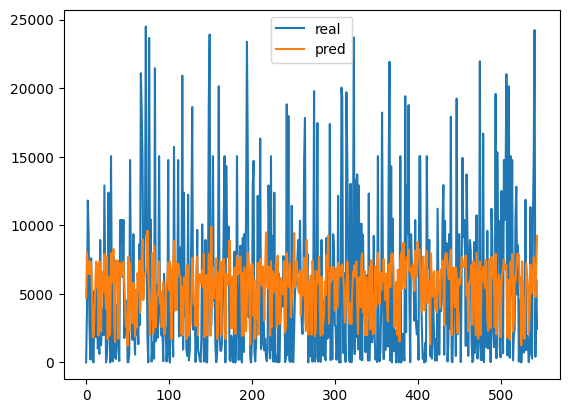

In [883]:
import matplotlib.pyplot as plt

x_axis = list(range(len(y_valid)))
plt.plot(x_axis, y_valid , label= "real")
plt.plot(x_axis, tree_reg.predict(X_valid),label= "pred")
plt.legend()

In [884]:
df[['관광지개수','ratio','카드사용금액','조회수','평점','인기점수','콘텐츠분류','오버투어리즘']].describe().iloc[1:,:]

#좋아요, 리뷰수, 북마크수, 소셜, 사진공유, 유네스코

,관광지개수,ratio,카드사용금액,조회수,평점,인기점수,오버투어리즘
mean,237.765839,15.674456,118.620120,7565.661815,1.96875,1.516357e+04,1.251860e+04
std,132.881972,18.771853,111.641775,27607.961911,2.29502,5.537344e+04,1.415000e+05
min,15.000000,2.180000,19.000000,0.000000,0.00000,0.000000e+00,1.844324e-01
25%,134.000000,7.160000,45.400000,1437.750000,0.00000,2.879000e+03,8.385727e+02
50%,270.000000,9.520000,99.400000,2427.000000,0.00000,4.859500e+03,3.720390e+03
75%,335.000000,12.990000,142.500000,4871.500000,5.00000,9.784750e+03,1.032497e+04
max,439.000000,99.340000,657.800000,682849.000000,5.00000,1.369236e+06,6.589419e+06


In [885]:
# 의사결정에 기여를 많이한 정도
#feature_cols = ['관광지개수','ratio','카드사용금액','조회수','평점','좋아요수','리뷰수','북마크수','소셜네트워크공유수','인기점수','사진공유수','콘텐츠분류','유네스코유무']

                    #읍       #읍         #읍        #읍
#feature_cols = ['관광지개수','ratio','카드사용금액','조회수','북마크수','인기점수','사진공유수']


pd.DataFrame({'feature':feature_cols, 'importance':tree_reg.feature_importances_})

,feature,importance
0,관광지개수,968
1,ratio,550
2,카드사용금액,968
3,조회수,2427
4,좋아요수,499
5,북마크수,1542
6,인기점수,267
7,콘텐츠분류,278
